## **Barrier Options and the Binomial Model**

### **Introduction**
Barrier options are a class of exotic options where the **payoff depends on whether the underlying asset crosses a specified price level (barrier) during the option's lifetime**. These options can either:
- **"Knock-in"** (become activated upon crossing the barrier)
- **"Knock-out"** (become deactivated upon crossing the barrier)

#### **Types of Barrier Options**
1. **Down-and-In** (DAI) → Option activates when price **falls below** the barrier.
2. **Down-and-Out** (DAO) → Option cancels when price **falls below** the barrier.
3. **Up-and-In** (UAI) → Option activates when price **rises above** the barrier.
4. **Up-and-Out** (UAO) → Option cancels when price **rises above** the barrier.

---

### **Why Can't We Use Black-Scholes for Barrier Options?**
The **Black-Scholes model** is based on the assumption that:
1. The **underlying price follows a continuous stochastic process**.
2. The option **depends only on the terminal price** at expiration.
3. There are **no price-dependent barriers** affecting the payoff.

However, **barrier options are path-dependent**—meaning we need to track the entire price evolution, not just the final price at expiration. **This violates the assumptions of Black-Scholes**.

**Solution?**  
A **binomial tree model** can effectively price barrier options by **tracking price movements at each time step and applying knock-in/knock-out conditions**.


### **Using the Binomial Model for Barrier Options**
A binomial tree **models stock prices step-by-step**, allowing us to:
- **Track whether the barrier is breached**.
- **Knock out the option dynamically** in the backward induction process.
- **Compute survival probabilities** to handle knock-in/out behavior.

### **Mathematical Formulation of the Binomial Tree**
#### **FX Price Evolution**
At each time step $dt$, the FX price moves:
$
S_{i+1}^u = S_i \times u, \quad S_{i+1}^d = S_i \times d
$
where:
$
u = e^{\sigma \sqrt{dt}}, \quad d = \frac{1}{u}
$
The **risk-neutral probability** of an **up-move** is:
$
q = \frac{e^{(r_d - r_f) dt} - d}{u - d}
$

#### **Option Value Backward Induction**
Using discounted expectation:
$
P_{i, j} = e^{-r_d dt} \times \left( q \times P_{i+1, j} + (1 - q) \times P_{i+1, j+1} \right)
$
If the **barrier condition is met** (knock-out), we set:
$
P_{i, j} = 0
$

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import networkx as nx
sys.path.append(os.path.abspath("../src"))  # Dynamically add src folder
from binomial_barrier_option import BinomialBarrierOption
from black_scholes import BlackScholes

In [15]:
# Define test parameters
spot_price = 120       # Current price of the underlying asset
strike_price = 100     # Strike price of the option
barrier_level = 110     # Barrier level (for down options)
time_to_maturity = 1   # Time to maturity (in years)
volatility = 0.2       # Volatility (annualized)
domestic_rate = 0.05   # Domestic risk-free interest rate
foreign_rate = 0.02    # Foreign risk-free interest rate
num_steps = 500        # Steps in binomial tree for accuracy

# Initialize Black-Scholes model for vanilla options
bs_model = BlackScholes(spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate)
call_vanilla_price = bs_model.calculate_vanilla_price("call")
put_vanilla_price = bs_model.calculate_vanilla_price("put")

# Compute barrier option prices using BinomialBarrierOption
call_down_in_price = BinomialBarrierOption(spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level, "down-in", "call", num_steps).price()
call_down_out_price = BinomialBarrierOption(spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level, "down-out", "call", num_steps).price()
call_up_in_price = BinomialBarrierOption(spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level, "up-in", "call", num_steps).price()
call_up_out_price = BinomialBarrierOption(spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level, "up-out", "call", num_steps).price()

put_down_in_price = BinomialBarrierOption(spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level, "down-in", "put", num_steps).price()
put_down_out_price = BinomialBarrierOption(spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level, "down-out", "put", num_steps).price()
put_up_in_price = BinomialBarrierOption(spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level, "up-in", "put", num_steps).price()
put_up_out_price = BinomialBarrierOption(spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level, "up-out", "put", num_steps).price()

# Store results in a table
results_table = pd.DataFrame({
    "Vanilla Option": ["Call Vanilla", "Call Vanilla", "Put Vanilla", "Put Vanilla"],
    "Barrier Option 1": ["Call (Down-In)", "Call (Up-In)", "Put (Down-In)", "Put (Up-In)"],
    "Price 1": [call_down_in_price, call_up_in_price, put_down_in_price, put_up_in_price],
    "Barrier Option 2": ["Call (Down-Out)", "Call (Up-Out)", "Put (Down-Out)", "Put (Up-Out)"],
    "Price 2": [call_down_out_price, call_up_out_price, put_down_out_price, put_up_out_price],
    "Sum (Option 1 + Option 2)": [call_down_in_price + call_down_out_price,
                                   call_up_in_price + call_up_out_price,
                                   put_down_in_price + put_down_out_price,
                                   put_up_in_price + put_up_out_price],
    "Vanilla Price": [call_vanilla_price, call_vanilla_price, put_vanilla_price, put_vanilla_price],
})

# Display the results
results_table


,Vanilla Option,Barrier Option 1,Price 1,Barrier Option 2,Price 2,Sum (Option 1 + Option 2),Vanilla Price
0,Call Vanilla,Call (Down-In),24.061157,Call (Down-Out),2.489017e-07,24.061158,24.061144
1,Call Vanilla,Call (Up-In),24.061157,Call (Up-Out),3.282196e-23,24.061157,24.061144
2,Put Vanilla,Put (Down-In),1.560259,Put (Down-Out),0.000000e+00,1.560259,1.560245
3,Put Vanilla,Put (Up-In),1.560259,Put (Up-Out),2.315301e-19,1.560259,1.560245


### **Validating Theoretical Identities of Barrier Options**
Barrier options must satisfy the following relationships based on financial theory:

$
\text{Call (Down-In)} + \text{Call (Down-Out)} = \text{Call Vanilla}
$

$
\text{Call (Up-In)} + \text{Call (Up-Out)} = \text{Call Vanilla}
$

$
\text{Put (Down-In)} + \text{Put (Down-Out)} = \text{Put Vanilla}
$

$
\text{Put (Up-In)} + \text{Put (Up-Out)} = \text{Put Vanilla}
$

These relationships arise because:
1. A **knock-in option** only becomes active **if the barrier is breached**.
2. A **knock-out option** ceases to exist **if the barrier is breached**.
3. The sum of both options should replicate the **payoff of a vanilla European option**.


### **Displaying the Results in a Table**
The table above verifies whether the **sum of knock-in and knock-out options** correctly approximates the vanilla option price.

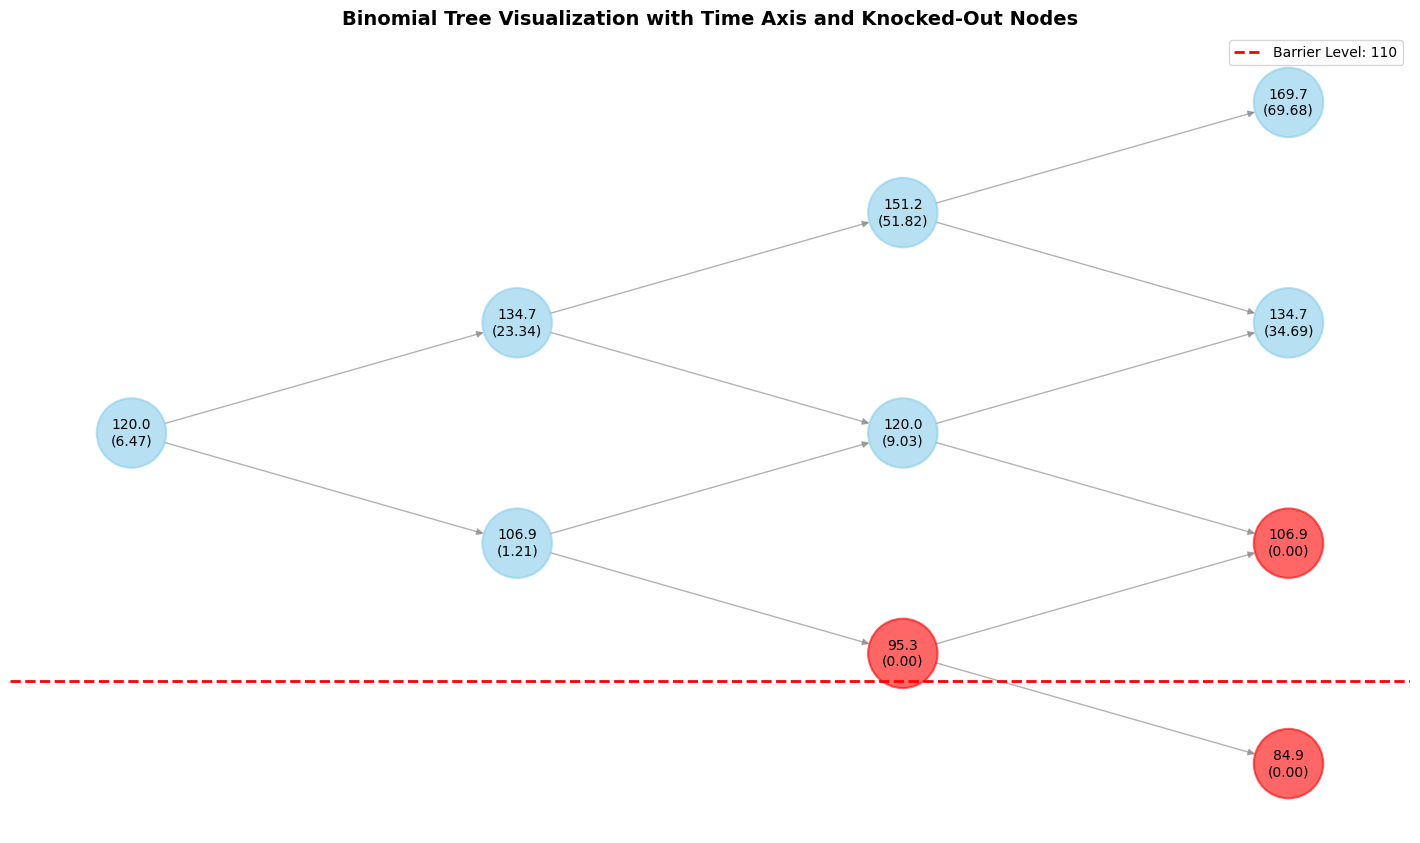

In [18]:

def visualize_binomial_tree(option_model, steps=10):
    """
    Creates an enhanced visualization of a binomial tree with option prices, time steps, 
    and red nodes for knocked-out options.

    option_model: Instance of BinomialBarrierOption containing option details.
    steps: Number of steps to visualize (smaller than actual for readability).
    """
    dt = option_model.T / steps
    u = np.exp(option_model.sigma * np.sqrt(dt))
    d = 1 / u

    # Generate binomial tree values
    stock_tree = np.zeros((steps + 1, steps + 1))
    option_tree = np.zeros((steps + 1, steps + 1))
    survival_tree = np.ones((steps + 1, steps + 1))

    for i in range(steps + 1):
        for j in range(i + 1):
            stock_tree[i, j] = option_model.S * (u ** (i - j)) * (d ** j)

            # Apply knock-out condition
            if option_model.barrier_type == "down-out" and stock_tree[i, j] <= option_model.B:
                survival_tree[i, j] = 0  # Knocked out
            elif option_model.barrier_type == "up-out" and stock_tree[i, j] >= option_model.B:
                survival_tree[i, j] = 0  # Knocked out

    # Compute final payoffs
    for j in range(steps + 1):
        if option_model.option_type == "call":
            option_tree[steps, j] = max(stock_tree[steps, j] - option_model.K, 0)
        elif option_model.option_type == "put":
            option_tree[steps, j] = max(option_model.K - stock_tree[steps, j], 0)

        option_tree[steps, j] *= survival_tree[steps, j]  # Apply survival probability

    # Backward induction for option price
    p = (np.exp((option_model.rd - option_model.rf) * dt) - d) / (u - d)
    discount = np.exp(-option_model.rd * dt)

    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            survival_probability = (p * survival_tree[i + 1, j] + (1 - p) * survival_tree[i + 1, j + 1])
            survival_tree[i, j] = survival_probability

            option_tree[i, j] = discount * (p * option_tree[i + 1, j] + (1 - p) * option_tree[i + 1, j + 1])
            option_tree[i, j] *= survival_probability

    # Plotting the binomial tree with time labels and knockout nodes in red
    G = nx.DiGraph()
    pos = {}
    labels = {}
    node_colors = []

    # Create nodes with time steps and color for knocked-out options
    for i in range(steps + 1):
        for j in range(i + 1):
            node_label = f"{stock_tree[i, j]:.1f}\n({option_tree[i, j]:.2f})"
            pos[(i, j)] = (i * (option_model.T / steps), -j + (i / 2))  # Time-aligned layout
            labels[(i, j)] = node_label
            G.add_node((i, j), price=stock_tree[i, j])

            # Knocked-out nodes should be red
            node_colors.append("red" if survival_tree[i, j] == 0 else "skyblue")

    # Create edges
    for i in range(steps):
        for j in range(i + 1):
            G.add_edge((i, j), (i + 1, j), weight=p)
            G.add_edge((i, j), (i + 1, j + 1), weight=1 - p)

    # Draw the tree with better aesthetics
    plt.figure(figsize=(14, 8))
    nx.draw(G, pos, with_labels=False, node_size=2500, node_color=node_colors, edge_color="gray", alpha=0.6, linewidths=1.5)

    # Draw labels with a larger font for clarity
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="black")

    # Add time labels on the x-axis
    time_labels = {i * (option_model.T / steps): f"T={i * (option_model.T / steps):.2f}" for i in range(steps + 1)}
    plt.xticks(list(time_labels.keys()), list(time_labels.values()), fontsize=10)

    # Draw the barrier level with improved annotation
    barrier_y = -np.log(option_model.B / option_model.S) / np.log(u / d) + (steps / 4)  # Adjust position
    plt.axhline(y=-barrier_y, color="red", linestyle="--", linewidth=2, label=f"Barrier Level: {option_model.B}")
    
    plt.title("Binomial Tree Visualization with Time Axis and Knocked-Out Nodes", fontsize=14, fontweight="bold")
    plt.xlabel("Time (Years)", fontsize=12)
    plt.ylabel("Stock Price Evolution", fontsize=12)
    plt.legend()
    plt.show()
    
# Visualize the binomial tree with knockout conditions
option_model = BinomialBarrierOption(spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level, "down-out", "call", steps=3)
visualize_binomial_tree(option_model, steps=3)


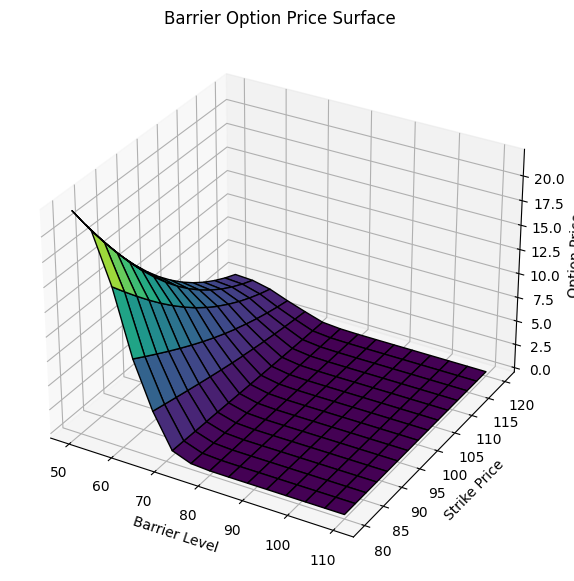

In [20]:
from mpl_toolkits.mplot3d import Axes3D

# Define a range of barrier and strike prices
barrier_range = np.linspace(50, 110, 15)
strike_range = np.linspace(80, 120, 15)
X, Y = np.meshgrid(barrier_range, strike_range)
Z = np.zeros_like(X)

# Compute option prices
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        option = BinomialBarrierOption(
            spot_price=100, strike_price=Y[i, j], time_to_maturity=1, volatility=0.2, 
            domestic_rate=0.05, foreign_rate=0.02, barrier_level=X[i, j], barrier_type="down-out", 
            option_type="call", steps=500).price()
        Z[i, j] = option

# Create 3D surface plot
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="black")
ax.set_title("Barrier Option Price Surface")
ax.set_xlabel("Barrier Level")
ax.set_ylabel("Strike Price")
ax.set_zlabel("Option Price")
plt.show()
